### Decision Tree Classifier fitted by cross validation

 1. Clean the data: Add target variable and remove redundant variable
 2. Cross validation over train+validation set combined, choose optimal model in termos of 0-1 loss for different size trees
 3. Measure accuracy over test set and AUC

In [1]:
import numpy as np
import pandas as pd

def data_cleaner(df):
    data =  df.copy()
    #remove the id, partlybad columns
    data.drop(["id","partlybad"],1,inplace=True)
    #set new index using the date column
    data.set_index(["date"],inplace=True)
    #add binary 'class2' col for event/non-event
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    #arrange to put class2 col at the front
    cols = ['class2'] + [col for col in data if col != 'class2']
    data = data[cols]
    return data


import os
# od.chdir('https://raw.githubusercontent.com/williwilliams3/TermProjectIML/master')
os.chdir('/Users/bwilliams/GoogleDrive/UniversityOfHelsinki/Fall2020/IML/TeamProject/TermProjectIML/')

#load training data
url = "data/train.csv"
npf_train_raw = pd.read_csv(url)
npf_train = data_cleaner(npf_train_raw)

#create feature array and target column for training data
X_train = npf_train.drop(["class2","class4"], axis=1)
y_train = npf_train["class2"]

# load validation data
url = "data/validation.csv"
npf_val_raw = pd.read_csv(url)
npf_val = data_cleaner(npf_val_raw)

#create feature array and target column for validation data
X_val = npf_train.drop(["class2","class4"], axis=1)
y_val = npf_train["class2"]

#import test data
npf_test_raw = pd.read_csv("data/test.csv")
npf_test = data_cleaner(npf_test_raw)

#create feature array and target column for test data
X_test = npf_train.drop(["class2","class4"], axis=1)
y_test = npf_train["class2"]


# create complete training set for cross validation with  train +  validation set
npf_train_val_raw = npf_train_raw.append(npf_val_raw)
npf_train_val = data_cleaner(npf_train_val_raw)
X = npf_train.drop(["class2","class4"], axis=1)
y = npf_train["class2"]


Cross validation Accuracy:  0.8530769230769231 {'max_depth': 2}


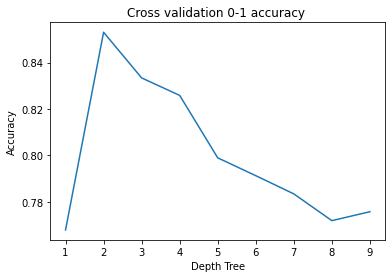

Accuracy on Test: 0.8798449612403101


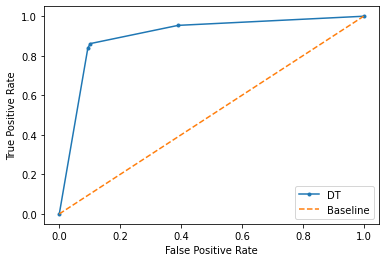

In [2]:
#####################################

from sklearn import tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
parameters = {'max_depth':range(1,10)}
clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), parameters, n_jobs=4, cv=10)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_

print ('Cross validation Accuracy: ', clf.best_score_, clf.best_params_) 

cv_accuracy = clf.cv_results_['mean_test_score']
plt.plot(range(1,10) ,cv_accuracy)
plt.title('Cross validation 0-1 accuracy ')
plt.xlabel('Depth Tree')
plt.ylabel('Accuracy')
plt.show()

y_pred = tree_model.predict(X_test)
# probabilities of class event
y_pred_proba = tree_model.predict_proba(X_test)[:,0]


from sklearn import metrics
print("Accuracy on Test:",metrics.accuracy_score(y_test, y_pred))

y_test_01 = pd.get_dummies(y_test)['event']

fpr, tpr, thresholds = metrics.roc_curve(y_test_01, y_pred_proba)
metrics.auc(fpr, tpr)

plt.plot(fpr,tpr , marker='.', label='DT')
plt.plot(fpr, fpr, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


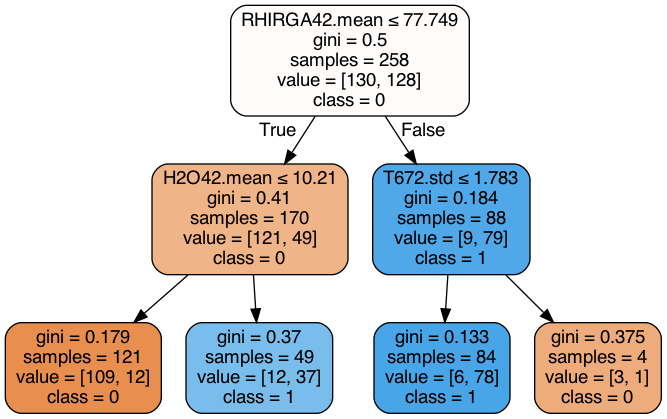

In [3]:
# Tree visualizatin
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

feature_cols = X.columns
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('data/tree1.png')
Image(graph.create_png())